In [ ]:
!pip install gdown

In [ ]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1EsrFTPGfGFwQ9hfhHmEsgSMSeWBrrxgP' -O mnist.pkl.gz

--2022-03-22 06:47:08--  https://drive.google.com/uc?export=download&id=1EsrFTPGfGFwQ9hfhHmEsgSMSeWBrrxgP
Resolving drive.google.com (drive.google.com)... 142.251.18.138, 142.251.18.100, 142.251.18.113, ...
Connecting to drive.google.com (drive.google.com)|142.251.18.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-0c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a3d2judbv0ishk5ndqmehqjeree1gisk/1647931575000/09089158620609118346/*/1EsrFTPGfGFwQ9hfhHmEsgSMSeWBrrxgP?e=download [following]
--2022-03-22 06:47:10--  https://doc-0k-0c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a3d2judbv0ishk5ndqmehqjeree1gisk/1647931575000/09089158620609118346/*/1EsrFTPGfGFwQ9hfhHmEsgSMSeWBrrxgP?e=download
Resolving doc-0k-0c-docs.googleusercontent.com (doc-0k-0c-docs.googleusercontent.com)... 108.177.126.132, 2a00:1450:4013:c01::84
Connecting to doc-0k-0c-docs.googleusercontent.com (doc-0k-0c-doc

The following 2 cells contain adapted codes from http://neuralnetworksanddeeplearning.com/chap1.html (written by Michael Nielsen).

Small changes were necessary to run on Python 3.

Also, I've modified some parts of the code for different reasons (e.g. to plot train vs. validation loss on each epoch).

In [ ]:
"""
mnist_loader
~~~~~~~~~~~~
A library to load the MNIST image data.  For details of the data
structures that are returned, see the doc strings for ``load_data``
and ``load_data_wrapper``.  In practice, ``load_data_wrapper`` is the
function usually called by our neural network code.
"""

#### Libraries
# Standard library
import pickle
import gzip

# Third-party libraries
import numpy as np

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.
    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.
    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.
    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.
    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f,encoding='iso-8859-1')
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.
    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.
    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.
    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results))
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [ ]:
# Standard library
import random

# Third-party libraries
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

class Network(object):
	def __init__(self,sizes): #the list sizes contains the number of neurons in the respective layers.
		self.num_layers = len(sizes)  #the number of the layers in Network
		self.sizes = sizes
		self.biases = [np.random.randn(y,1) for y in sizes[1:]]
		self.weights = [np.random.randn(y,x) 
						for x,y in zip(sizes[:-1],sizes[1:])]

	def feedforward(self,a):
		"""Return the output of the network if "a" is input"""
		for b,w in zip(self.biases,self.weights):
			a = sigmoid(np.dot(w,a) + b)        
		return a
  
	def calc_loss_metric(self, data, train=False):
			loss = 0
			for x,y in data:
				ffx = self.feedforward(x)
				if not train:
					y = [[0.] if y!=i else [1.] for i in range(10)]
				loss += (ffx-y)**2
			loss = sum(loss)[0]/len(loss)
			return loss if train else loss*5;
		
	def SGD(self, training_data, epochs, mini_batch_size,eta,test_data):
		"""
		Train the neural network using mini-batch stochastic gradient descent.
		The "training_data" is a list of tuples "(x,y)" representing the training inputs
		and the desired output. The other non-optional parameters are self-explanatory.
		If "test_data" is provided then the network will be evaluated against the test 
		data after each epoch, and partial progress printed out. This is useful for tracking
		process, but slows things down substantially.
		"""
		tlosses = []
		vlosses = []
		n_test = len(test_data)
		n = len(training_data)
		for j in range(epochs):
			random.shuffle(training_data)        #rearrange the training_data randomly
			mini_batches = [ training_data[k:k + mini_batch_size]
										   for k in range(0, n, mini_batch_size)]
			for mini_batch in mini_batches:
				self.update_mini_batch(mini_batch,eta)
    
			#calculate metrics and print them
			train_loss = self.calc_loss_metric(training_data, train=True)
			val_loss = self.calc_loss_metric(test_data)
			train_acc = self.evaluate(training_data, train=True)
			print("Epoch {0}: train_loss: {1}, train_acc: {2} / {3}, val_loss: {4}, val_acc: {5} / {6}"
				.format(j, train_loss, train_acc, n, val_loss, self.evaluate(test_data), n_test))

			tlosses.append(train_loss)
			vlosses.append(val_loss)

		#plot training losses & validation losses against epochs
		plot_losses(tlosses, vlosses, epochs)

	def update_mini_batch(self,mini_batch,eta):
		"""
		Update the network's weights and biases by applying gradient descent using backpropagation
		to a single mini batch. The "mini_batch" is a list of tuples "(x,y)" and "eta" is the learning
		rate.
		"""
		nabla_b = [np.zeros(b.shape) for b in self.biases]
		nabla_w = [np.zeros(w.shape) for w in self.weights]
		for x, y in mini_batch:
			delta_nabla_b, delta_nabla_w = self.backprop(x, y)
			nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
			nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
		self.weights = [w-(eta/len(mini_batch))*nw 
						for w, nw in zip(self.weights, nabla_w)]
		self.biases = [b-(eta/len(mini_batch))*nb 
					   for b, nb in zip(self.biases, nabla_b)]
	
	def backprop(self, x, y):
		"""Return a tuple ``(nabla_b, nabla_w)`` representing the
		gradient for the cost function C_x.  ``nabla_b`` and
		``nabla_w`` are layer-by-layer lists of numpy arrays, similar
		to ``self.biases`` and ``self.weights``."""
		nabla_b = [np.zeros(b.shape) for b in self.biases]
		nabla_w = [np.zeros(w.shape) for w in self.weights]
		# feedforward
		activation = x
		activations = [x] # list to store all the activations, layer by layer
		zs = [] # list to store all the z vectors, layer by layer
		for b, w in zip(self.biases, self.weights):
			z = np.dot(w, activation)+b
			zs.append(z)
			activation = sigmoid(z)
			activations.append(activation)
		# backward pass
		delta = self.cost_derivative(activations[-1], y) * \
			sigmoid_prime(zs[-1])
		nabla_b[-1] = delta
		nabla_w[-1] = np.dot(delta, activations[-2].transpose())
		# Note that the variable l in the loop below is used a little
		# differently to the notation in Chapter 2 of the book.  Here,
		# l = 1 means the last layer of neurons, l = 2 is the
		# second-last layer, and so on.  It's a renumbering of the
		# scheme in the book, used here to take advantage of the fact
		# that Python can use negative indices in lists.
		for l in range(2, self.num_layers):
			z = zs[-l]
			sp = sigmoid_prime(z)
			delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
			nabla_b[-l] = delta
			nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
		return (nabla_b, nabla_w)

	def evaluate(self, test_data, train=False):
		"""Return the number of test inputs for which the neural
		network outputs the correct result. Note that the neural
		network's output is assumed to be the index of whichever
		neuron in the final layer has the highest activation."""
		test_results = [(np.argmax(self.feedforward(x)), np.argmax(y) if train else y)
						for (x, y) in test_data]
		return sum(int(x == y) for (x, y) in test_results)

	def cost_derivative(self, output_activations, y):
		"""Return the vector of partial derivatives \partial C_x /
		\partial a for the output activations."""
		return (output_activations-y)
		
#### Miscellaneous functions
def sigmoid(z):
	"""The sigmoid function."""
	return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
	"""Derivative of the sigmoid function."""
	return sigmoid(z)*(1-sigmoid(z))
 
def plot_losses(tlosses, vlosses, epochs):
		figure(figsize=(8, 6), dpi=80)
		plt.plot([i for i in range(epochs)], tlosses, label='Train Loss')
		plt.plot([i for i in range(epochs)], vlosses, label='Validation Loss')
		plt.locator_params(axis="x", integer=True)
		plt.xlabel("Epoch")
		plt.ylabel("Loss")
		plt.legend()

In [ ]:
training_data, validation_data, test_data = load_data_wrapper()

In [ ]:
net = Network([784, 30, 10])

Epoch 0: train_loss: 527.2711502672917, train_acc: 46888 / 50000, val_loss: 538.2981460026981, val_acc: 9361 / 10000
Epoch 1: train_loss: 476.98826499097885, train_acc: 47165 / 50000, val_loss: 509.2424147301625, val_acc: 9384 / 10000
Epoch 2: train_loss: 452.4236407637437, train_acc: 47366 / 50000, val_loss: 502.13788799549457, val_acc: 9393 / 10000
Epoch 3: train_loss: 426.2813093810555, train_acc: 47517 / 50000, val_loss: 492.753862152473, val_acc: 9395 / 10000
Epoch 4: train_loss: 408.79522617845345, train_acc: 47605 / 50000, val_loss: 483.28045485616536, val_acc: 9422 / 10000
Epoch 5: train_loss: 383.47197500606023, train_acc: 47786 / 50000, val_loss: 474.87215034855365, val_acc: 9441 / 10000
Epoch 6: train_loss: 362.4729316253977, train_acc: 47943 / 50000, val_loss: 457.5082507509886, val_acc: 9458 / 10000
Epoch 7: train_loss: 347.862036519611, train_acc: 48012 / 50000, val_loss: 450.527666942967, val_acc: 9454 / 10000
Epoch 8: train_loss: 344.23200450432273, train_acc: 48035 / 5

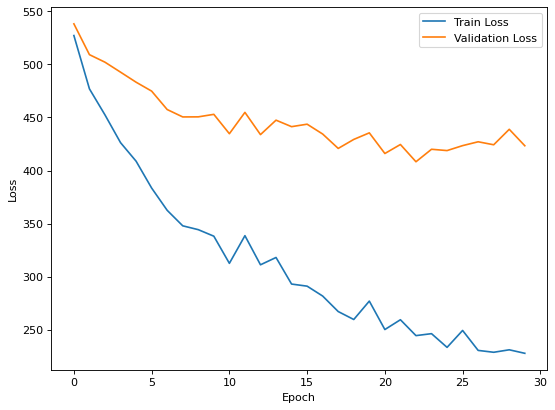

In [ ]:
net.SGD(training_data, 30, 10, 3.0, test_data=test_data)